In [1]:
from src.utils.results_utils import *

from src.utils.data_utils import str_dict_to_values

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import nbformat
import os

[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading names: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


# 0. Loading the cleaned dataset

In [2]:
df_char_cleaned = pd.read_csv('data/cleaned.csv')

df_char_cleaned['Languages'] = df_char_cleaned['Languages'].apply(str_dict_to_values)
df_char_cleaned['Country'] = df_char_cleaned['Country'].apply(str_dict_to_values)
df_char_cleaned['Genres'] = df_char_cleaned['Genres'].apply(str_dict_to_values)

# 1. Presenting the Data

The cleaned dataset looks like this : 

In [3]:
# Create a copy of the original DataFrame to rename columns
df_char_cleaned_column = df_char_cleaned.copy()

# Rename columns to be clearer
df_char_cleaned_column.columns = [
    'Wikipedia ID', 'Movie Name', 'Languages', 'Production Country', 
    'Movie Genre', 'Character Name', 'Gender', 'Actor Age', 'Release Date'
]

# Display a random sample of 5 rows from the new DataFrame
df_char_cleaned_column.sample(5)

,Wikipedia ID,Movie Name,Languages,Production Country,Movie Genre,Character Name,Gender,Actor Age,Release Date
30801,22541211,Manmadhan,[Tamil Language],[India],"[Musical, Drama, Bollywood, World cinema]",Vaishnavi,F,20.0,2004
80785,3763760,Cashback,"[English Language, Spanish Language]",[United Kingdom],"[Romance Film, Drama, Comedy]",Alex,M,44.0,2006-05-18
76903,11350697,Sherlock Holmes and the Secret Weapon,[English Language],[United States of America],"[Thriller, Detective fiction, Detective, Black...",Holmes,M,NaN,1943-02-12
20905,5098517,My Boss's Daughter,[English Language],[United States of America],"[Romantic comedy, Romance Film, Comedy, Slapst...",Taylor,M,65.0,2003-08-22
14133,394792,Jackie Brown,[English Language],[United States of America],"[Thriller, Crime Fiction, Indie, Action/Advent...",Ordell,M,49.0,1997-12-25


In [4]:
value_count_per_column = df_char_cleaned.notnull().sum()

# Define the data
data = go.Bar(
    x=df_char_cleaned_column.columns,  
    y=value_count_per_column.values,  
    marker=dict(
        color='skyblue' 
    ),
    text=[f"{count}" for count in value_count_per_column.values], 
    hoverinfo='text',  
    textposition='none'  
)

# Create the layout
layout = go.Layout(
    title='Number of Values in Each Category of the Cleaned Dataset',  
    xaxis=dict(title='Dataset Columns'),  
    yaxis=dict(title='Number of Values'),  
    barmode='group'  

)

fig = go.Figure(data=[data], layout=layout)

# Plot the graph
fig.show()

We observe that the dataset contains 160,432 entries. Some values are missing in the columns Gender, Actor Age, and Release Date.

In [5]:
total_count = len(df_char_cleaned['Character_name'])
name_count = df_char_cleaned['Character_name'].nunique()
movie_count = df_char_cleaned['Wikipedia_ID'].nunique()

summary_df = pd.DataFrame({
    'Category': ['Total Character Names','Unique Character Names', 'Unique Movies'],
    'Count': [total_count, name_count, movie_count]
})

summary_df.head()

,Category,Count
0,Total Character Names,159691
1,Unique Character Names,37883
2,Unique Movies,31072


In [6]:
plot_sex_distribution_with_top_names(df_char_cleaned)

In [7]:
# Create a df with the name count per gender
df_count_gender = df_char_cleaned.groupby('Sex')['Character_name'].count()

# Create a df that show the distribution 
summary_df = pd.DataFrame({
    'Gender': df_count_gender.index,
    'Distribution (%)': df_count_gender.values/value_count_per_column['Sex']*100
})

summary_df.head()

,Gender,Distribution (%)
0,F,36.770114
1,M,63.229886


The dataset shows a slight imbalance between genders, with about half as many female entries as male. However, since there is still a substantial amount of data, this imbalance is unlikely to significantly impact the results. 

Additionally, according to a 2022 study by the Center for the Study of Women in Television and Film at San Diego State University, 34 % of leading characters in the top 100 popular films were women, compared to 66 % men. This supports the dataset's gender distribution as representative of broader industry trends.

In [8]:
# Creating the top 1000 most popular character names set
name_counts = df_char_cleaned['Character_name'].value_counts()
top_100_names = name_counts.head(1000)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=top_100_names.index,
    y=top_100_names.values,
    mode='lines+markers',
    name='Character Count',
    line=dict(color='skyblue'),
    hovertext=[f"Name: {name}<br>Count: {count}" for name, count in zip(top_100_names.index, top_100_names.values)],
    hoverinfo="text"
))

fig.update_layout(
    title='1000 Most Popular Character Names',
    xaxis_title='Character Name',
    yaxis_title='Count',
    xaxis=dict(showticklabels=False)
)

fig.show()

We can clearly see that John is the most popular name given to characters, with 1305 appartitions. One possible explanation is that John Doe was used in North America to refer to “any man whose name is unknown”. This could explain its appearance in this many movies, far ahead of the second most common name, Georges, with 621 appearances.

**P3 :**  Excluding the most common names, which may skew the predictive model due to their high frequency, could lead to more accurate results.

In [9]:
# df_char_cleaned.head()
df_char_cleaned_SA = df_char_cleaned.copy()
df_char_cleaned_SA.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0,2001-08-24
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,2001-08-24
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,2001-08-24
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,2001-08-24
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0,2001-08-24


# 2. General Analysis

## 2.1 Genre analysis

### 2.1.a Top names depending on Movie's Genre

*Interactive hover plot in this section*

In [10]:
analyze_genre = GenreAnalyzer(df_char_cleaned)

frequent_names_m, frequent_names_f = analyze_genre.get_top_names_by_genre(10)

data_f = analyze_genre.create_sunburst_data(frequent_names_f)
data_m = analyze_genre.create_sunburst_data(frequent_names_m)

In [11]:
# Create the sunburst plots for females and males
fig_females = go.Figure(go.Sunburst(
    labels=data_f['character'],
    parents=data_f['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_males = go.Figure(go.Sunburst(
    labels=data_m['character'],
    parents=data_m['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Females", "Males"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_females['data'][0], row=1, col=1)
fig.add_trace(fig_males['data'][0], row=1, col=2)

fig.update_layout(
    title_text="TOP 10 Names by Genre and Gender (Press on the Genre to see the names)",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig.show()

### 2.1.b Character Search Engine

We created a movie finder where a specific string can be found in one of the characters name within our dataset.

In [12]:
# Looking for the appearance of all the character with a name starting by the selected string

genre_counts_result, movies_with_name = analyze_genre.count_name_appearance_by_genre('Leo')
genre_counts_result.head(15)    # Print the genre of the movies where this character exists

,Genre_Category,Count
0,Action & Adventure,166
1,Drama,250
2,Comedy,142
3,Horror & Thriller,111
4,Fantasy & Sci-Fi,66
5,Historical & War,56
6,Romance,84
7,Documentary,21
8,Music & Performance,15
9,Cult & B-Movies,49


In [13]:
# General list of the movies where this character is
movies_with_name.head(5)

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date,Genre_Category
99,27611999,Special Effects,[],"[United States of America, United Kingdom]","[Thriller, Horror, Psychological thriller, Sus...",Leon,NaN,NaN,1984,"[Action & Adventure, Horror & Thriller, Drama,..."
539,21271533,Bleeder,[Danish Language],[Denmark],"[Thriller, Drama]",Leo,M,34.0,1999-08-06,"[Action & Adventure, Horror & Thriller, Drama]"
567,17379289,Without Warning,[English Language],[United States of America],"[Science Fiction, Horror]",Leo,M,60.0,1980-11-26,"[Fantasy & Sci-Fi, Horror & Thriller]"
731,13911991,A Sereia de Pedra,[French Language],"[France, Portugal]","[Silent film, Drama]",Leonor,F,NaN,1923-04-02,[Drama]
2046,20927265,Camões,[Portuguese Language],[Portugal],"[Biography, Drama]",Leonor,F,24.0,1946-09-20,"[Documentary, Drama]"


### 2.1.c Statistical analysis for Genre

In order to compare the influence of genre on the characters' names, we decided to run chi2 tests and a Cramér's V test. This will allow us to highlight a possible influence.

In [14]:
df_expanded = df_char_cleaned.explode('Genre_Category')

contingency_table = create_contingency_table(df_expanded,'Character_name','Genre_Category')
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 421199.3709942177
p-value: 0.0


The p-value is very close to zero, hence we can say taht there is an association between character names and genres. We will now try to quantify this association using Cramér's V.

In [15]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.3317263855364535


The Cramér's V is close to 0.35, meaning there is a moderate association between genres and character names.

## 2.2 Gender Analysis

The purpose of this section is to conjecture if wether or not a correlation between characters' names and their gender can be found. For that, we analyzed length, vowels and consonants' counts distributions in the names and compared it depending on character's gender.

In [16]:
analyze_gender = GenderAnalyzer(df_char_cleaned)
df_vowels, df_consonants = analyze_gender.get_vowel_stats()

### 2.2.a Vowels and consonants count

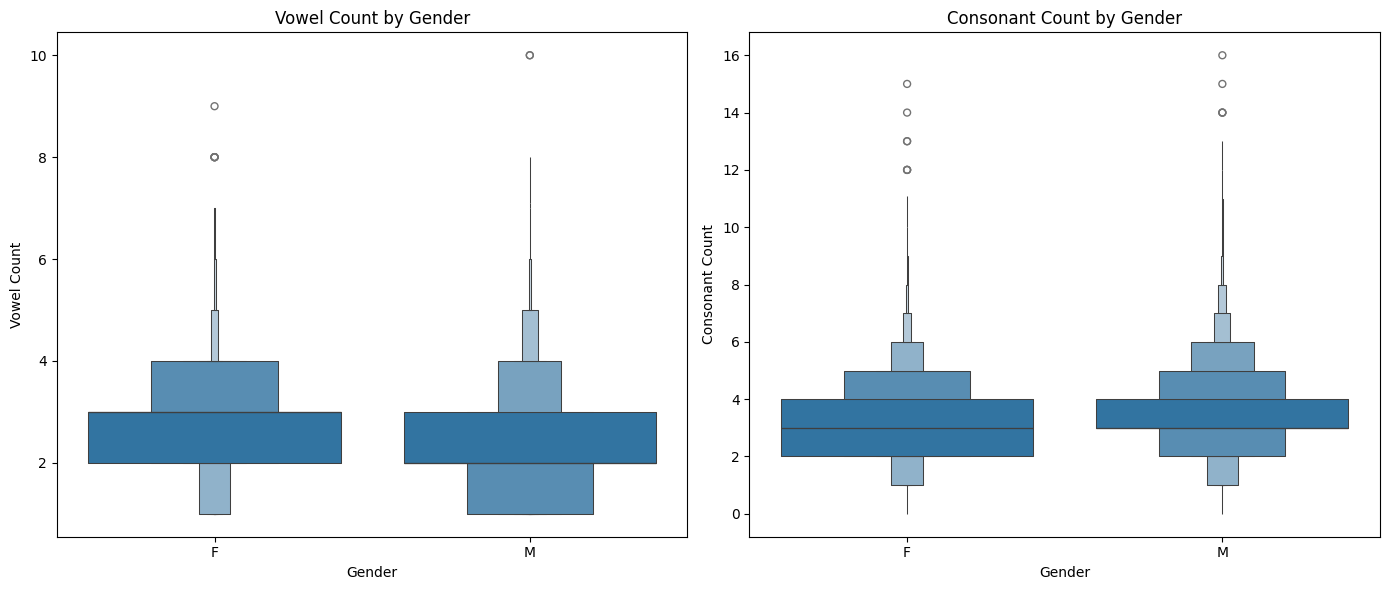

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

### 2.2.b Name Length per gender

In [18]:
df_length = analyze_gender.get_length_stats()

print('Length stats for character names by sex:')
df_length.head()

Length stats for character names by sex:


,mean,std
Sex,,
F,5.862596,1.672915
M,5.847955,1.845403


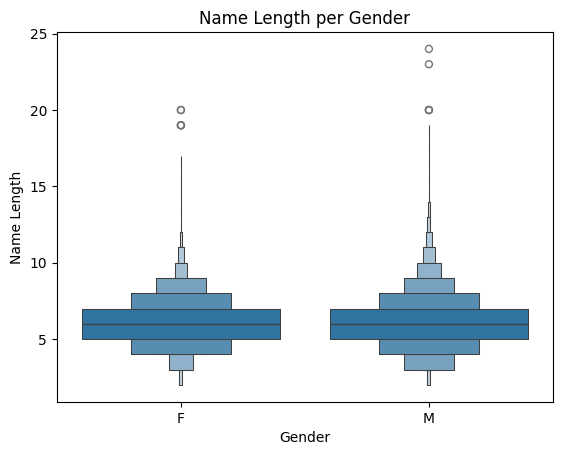

In [19]:
analyze_gender.create_boxenplot_by_sex()

### 2.2.c First and last letters of the characters' name depending on the gender

*Interactive hover plot in this section*

In [20]:
analyze_gender.plot_letter_name_percentage(0)
analyze_gender.plot_letter_name_percentage(-1)

#### 2.2.d Top names of characters across Age and Gender

*Interactive hover plot in this section*

In [21]:
analyze_gender.plot_age_sex_distribution_with_top_names()

## 2.3 Geographical Analysis

The aim of this section is to present the distribution of top character names across continents and countries.

### 2.3.a Continent Analysis

In [22]:
# Let's generate a table containing the most recurrent names for each continent
analyze_countries = CountryAnalyzer(df_char_cleaned)
df_continent = analyze_countries.create_continent_df()
df_continent.head()

,Continent,Female_name,Male_name
0,Africa,Amina*,Omar*
1,Asia,Priya,Vijay
2,Europe,La,John
3,North America,Sarah,John
4,Oceania,Angie,John


\* 3 other names are in a tie for this category. We choose to display only one name for readability

In the table above we see the most recurrent character names for each continent. For Asia, we see that the most common names are indian names. Is it because other nearby countries are influenced by the bollywood industry or because India's movies are predominent in this dataset? 
We will try to answer the question by plotting the most common character names per country and reting it with the number of movies from this country in the dataset.

### 2.3.b Country Analysis (Interractive World map)

*Interactive hover plot in this section*

In [23]:
df_top_names = analyze_countries.create_top_names_df()
analyze_countries.add_movie_count(df_top_names)
df_top_names = analyze_countries.cleaning_non_countries(df_top_names)

In [24]:
fig = go.Figure(go.Scattergeo(
))
fig.add_trace(go.Choropleth(
    locations= df_top_names['primary_country'],
    locationmode='country names',
    showscale= True,
    colorscale='YlOrRd',
    z=np.log10(df_top_names['Number_of_movies']),
    colorbar=dict(title="Number of movies (Log Scale)", tickvals=np.arange(0, 5), ticktext=[f"10^{i}" for i in range(0, 5)]),
    text= [f"Top female name: {female}<br>Top male name: {male}<br>Nb Movies: {movies:,}" 
           for female, male, movies in zip(df_top_names['Female_name'], df_top_names['Male_name'], df_top_names['Number_of_movies'])],
    hovertemplate="%{location}<br>%{text}"
))
fig.update_geos(
    projection_scale=1,center={'lat': 30},
    visible=False,
    showcountries=True, countrycolor="RebeccaPurple"
)
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        lakecolor="aqua"
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title_text="Most Common Male and Female Character Names by Country",
    title_x=0.4,
    title_y=0.90
)
fig.show()

### 2.3.c Statistical analysis (Geography)

We are going to run a chi2 test in order to verify that there is noticeable correlation between geography and characters' names

In [25]:
# Chi2 test
contingency_table = create_contingency_table(df_char_cleaned,'Character_name','primary_country')
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 7796708.1732684765
p-value: 0.0


Looking the results above, we see that we have a p-value equal to 0, meaning that there is a statistically significant association between the country of movie production and the character names in the movie. We will now investigate the strength of this association using Cramér's V.

In [26]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.6900272760393569


The Cramér's V is superior to 0.5 meaning that there is a strong association between the country of production of the movie and the name of the characters in the movies.

## Phonetics

In [27]:
# We will divide consonants by their manner of articulation
plosive = ['P','T','B','K']
fricative = ['F','X','0','S','H']
affricate = ['J']
nasal =['M','N']
liquid = ['L','R']
manner_groups = [plosive,fricative,affricate,nasal,liquid]
manner_names = ['plosive','fricative','affricate','nasal','liquid']


In [28]:
analyze_phonetics = PhoneticAnalyzer(df_char_cleaned,manner_groups,manner_names)


### Gender

In [29]:
manner_df = analyze_phonetics.phonetics_by_gender()

/Users/luca/Desktop/ada-2024-project-adadasurmonbidet2024/src/utils/results_utils.py:521: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



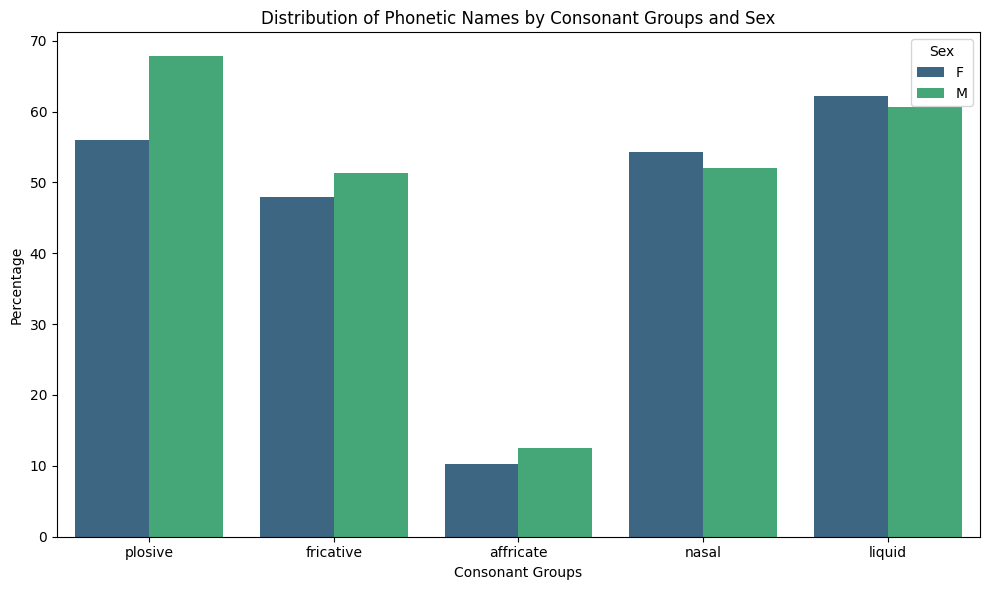

In [30]:
# Create the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=manner_df,
    x='Consonant_Group',
    y='Percent',
    hue='Sex',
    palette='viridis',
    order=[f'{manner}' for manner in manner_names]
)
x_positions = ax.get_xticks()
bar_width = 0.4

'''
for _, row in manner_df.iterrows():
        group_idx = manner_names.index(row['Consonant_Group'])
        if row['Sex'] == 'M':
                x = x_positions[group_idx] + bar_width / 2 
        else:
                x = x_positions[group_idx] - bar_width / 2
        plt.errorbar(
            x=x,
            y=row['Percent'],
            yerr=row['CI'],
            fmt='none',
            c='black',
            capsize=4
        )
'''
        
# Customize the plot
plt.title('Distribution of Phonetic Names by Consonant Groups and Sex')
plt.xlabel('Consonant Groups')
plt.ylabel('Percentage')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()


The plot above show that plosives, fricatives and affricates sounds are more common in male character names while nasal and liquid names are more common for female character names. Although not formally defined on a linguistic point of view, we can regroup plosives, fricatives and affricates sounds as 'hard' sounds and nasal and liquid sounds as 'soft' sounds. From this we can deduce that male names are more likely to contain 'hard' sounds and female names 'soft' sounds. 

### Age

In [31]:
manner_age_df = analyze_phonetics.phonetics_by_age()


In [32]:
#let's place the age groups in the correct order

age_order = ['<12y','13y-17y','18y-24y','25y-34y','35y-44y','45y-54y','55y-64y','65y-74y','75y-84y','>85y']
manner_age_df['age_category'] = pd.Categorical(
    manner_age_df['age_category'],
    categories=age_order,
    ordered=True
)

In [33]:
manner_age_df.head()

,Consonant_Group,age_category,Count,Percent
0,affricate,13y-17y,351,11.959114
1,affricate,18y-24y,1496,11.955566
2,affricate,25y-34y,4175,12.059852
3,affricate,35y-44y,3405,11.687376
4,affricate,45y-54y,2129,11.549938


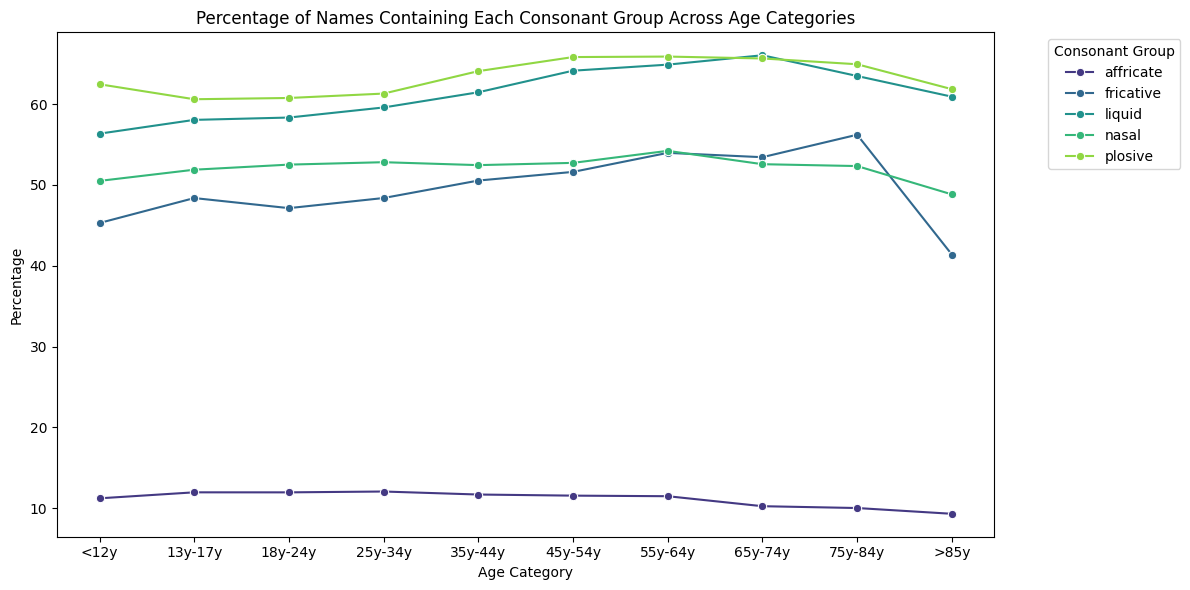

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=manner_age_df,
    x='age_category',
    y='Percent',
    hue='Consonant_Group',
    marker='o',
    palette='viridis'
)
plt.title('Percentage of Names Containing Each Consonant Group Across Age Categories')
plt.ylabel('Percentage')
plt.xlabel('Age Category')
plt.legend(title='Consonant Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3 Sentimental Analysis

This section marks the beginning of the sentiment analysis, focusing particularly on the preprocessing of the movies synopsies dataset. For each character in every movie, the goal was to identify the sentences involving them directly in the summaries using natural language processing (NLP).

To run this part, you will need to download the “corenlp_plot_summaries” locally, as we couldn't import it in the repository. You can find the result of our prepropccessing as "sentences_by_characters.csv" in the "data" folder. 

**P3 :**  Find a solution to import the "corenlp_plot_summaries" file directly on the github repository.

In [35]:
'''
df_char_cleaned = pd.read_csv('data/cleaned.csv', sep=',', header=0)

character_names_by_film = df_char_cleaned.groupby("Wikipedia_ID")["Character_name"].unique().reset_index()     
'''   

'\ndf_char_cleaned = pd.read_csv(\'data/cleaned.csv\', sep=\',\', header=0)\n\ncharacter_names_by_film = df_char_cleaned.groupby("Wikipedia_ID")["Character_name"].unique().reset_index()     \n'

In [36]:
'''
base_dir='data/corenlp_plot_summaries'
movie_ids = character_names_by_film["Wikipedia_ID"]

data = []

for index, movie_id in enumerate(movie_ids):
    file_path = os.path.join(base_dir, f"{movie_id}.xml.gz") 
    if os.path.exists(file_path):
        movie_nlp = parse_xml_gz(file_path)
        list_characters = character_names_by_film["Character_name"].iloc[index]
        for character_name in list_characters:
            filtered_sentences = filter_sentences_by_character(character_name, movie_nlp["sentences_data"], movie_nlp["coreferences"])
            character_sentences = []

            for sentence in filtered_sentences["character_sentences"]:
                character_sentences.append(sentence) 
            data.append({
                "Character_Name": character_name,
                "Wikipedia_ID": movie_id,
                "Sentences": character_sentences,
                })
                '''

'\nbase_dir=\'data/corenlp_plot_summaries\'\nmovie_ids = character_names_by_film["Wikipedia_ID"]\n\ndata = []\n\nfor index, movie_id in enumerate(movie_ids):\n    file_path = os.path.join(base_dir, f"{movie_id}.xml.gz") \n    if os.path.exists(file_path):\n        movie_nlp = parse_xml_gz(file_path)\n        list_characters = character_names_by_film["Character_name"].iloc[index]\n        for character_name in list_characters:\n            filtered_sentences = filter_sentences_by_character(character_name, movie_nlp["sentences_data"], movie_nlp["coreferences"])\n            character_sentences = []\n\n            for sentence in filtered_sentences["character_sentences"]:\n                character_sentences.append(sentence) \n            data.append({\n                "Character_Name": character_name,\n                "Wikipedia_ID": movie_id,\n                "Sentences": character_sentences,\n                })\n                '

In [37]:
'''
df = pd.DataFrame(data)
df = df[df['Sentences'].apply(lambda x: len(x) > 0)]
df['Sentence_Count'] = df['Sentences'].apply(len)
df.to_csv('data/sentences_by_character.csv', index=False)
print(df)
'''

"\ndf = pd.DataFrame(data)\ndf = df[df['Sentences'].apply(lambda x: len(x) > 0)]\ndf['Sentence_Count'] = df['Sentences'].apply(len)\ndf.to_csv('data/sentences_by_character.csv', index=False)\nprint(df)\n"

In [38]:
'''
#df = pd.read_csv('data/sentences_by_character.csv', sep=',', header=0)
df = pd.read_csv('data/sentences_by_character.csv')
print(df.shape)
'''

"\n#df = pd.read_csv('data/sentences_by_character.csv', sep=',', header=0)\ndf = pd.read_csv('data/sentences_by_character.csv')\nprint(df.shape)\n"

### Fonctions pour TextBlob SA

TextBlob uses two key metrics for sentiment analysis: Polarity and Subjectivity.

- **Polarity (P):** Measures sentiment on a scale from **-1** (most negative) to **1** (most positive).
- **Subjectivity (S):** Measures how subjective or objective the sentiment is, ranging from **0** (most objective) to **1** (most subjective).


| Polarity (P)    | Subjectivity (S) | Interpretation                |
|---------------------|------------------------|------------------------------------|
| [-1; -0.5]      | [0.5; 1]           | Very Negative & Subjective        |
| [-0.5; 0]       | [0; 0.5]           | Negative but Fairly Objective     |
| 0               | [0; 1]             | Neutral                           |
| [0; 0.5]        | [0; 0.5]           | Positive but Fairly Objective     |
| [0.5; 1]        | [0.5; 1]           | Very Positive & Subjective        |


In [39]:
'''
data_textblob = []  
list_characters = df["Character_Name"]

for index, character_name in enumerate(list_characters):
    list_sentences_by_character = df["Sentences"].iloc[index]
    movie_id = df["Wikipedia_ID"].iloc[index]
    
    mean_polarity_textblob, mean_subjectivity_textblob = process_character_sentiments_textblob(list_sentences_by_character)

    data_textblob.append({
        "Character_Name": character_name,
        "Wikipedia_id": movie_id,
        "Polarity": mean_polarity_textblob,
        "Subjectivity" : mean_subjectivity_textblob
    })

df_sentiment_analysis_textblob = pd.DataFrame(data_textblob)
print(df_sentiment_analysis_textblob)
'''

'\ndata_textblob = []  \nlist_characters = df["Character_Name"]\n\nfor index, character_name in enumerate(list_characters):\n    list_sentences_by_character = df["Sentences"].iloc[index]\n    movie_id = df["Wikipedia_ID"].iloc[index]\n    \n    mean_polarity_textblob, mean_subjectivity_textblob = process_character_sentiments_textblob(list_sentences_by_character)\n\n    data_textblob.append({\n        "Character_Name": character_name,\n        "Wikipedia_id": movie_id,\n        "Polarity": mean_polarity_textblob,\n        "Subjectivity" : mean_subjectivity_textblob\n    })\n\ndf_sentiment_analysis_textblob = pd.DataFrame(data_textblob)\nprint(df_sentiment_analysis_textblob)\n'

In [40]:
#Loading the sintimental analysis csv
df_sentiment_analysis_textblob = pd.read_csv('data/sentimental_analysis.csv')

### Interpretation of the results

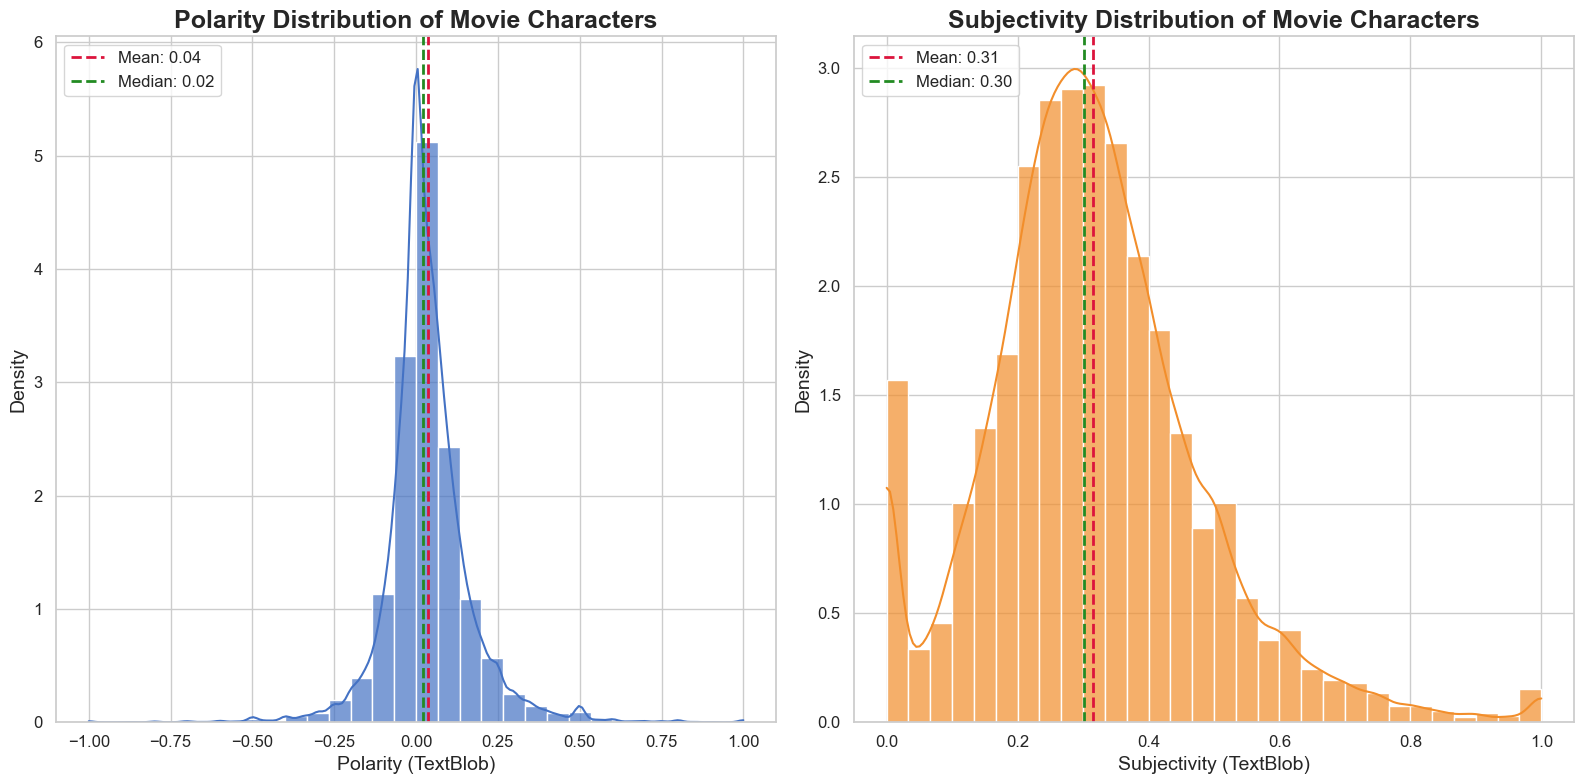

In [41]:
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(16, 8))

# Polarity Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(
    df_sentiment_analysis_textblob['Polarity'], 
    kde=True, color='#4472C4', bins=30, stat='density', alpha=0.7
)
mean_pol = df_sentiment_analysis_textblob['Polarity'].mean()
median_pol = df_sentiment_analysis_textblob['Polarity'].median()

# Add statistical annotations
plt.axvline(mean_pol, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_pol:.2f}')
plt.axvline(median_pol, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_pol:.2f}')
plt.title('Polarity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Polarity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Subjectivity Distribution Plot
plt.subplot(1, 2, 2)
sns.histplot(
    df_sentiment_analysis_textblob['Subjectivity'], 
    kde=True, color='#F28E2B', bins=30, stat='density', alpha=0.7
)
mean_sub = df_sentiment_analysis_textblob['Subjectivity'].mean()
median_sub = df_sentiment_analysis_textblob['Subjectivity'].median()

# Add statistical annotations
plt.axvline(mean_sub, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_sub:.2f}')
plt.axvline(median_sub, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_sub:.2f}')
plt.title('Subjectivity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Subjectivity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [42]:
from scipy.stats import pearsonr, shapiro

# Calcul du coefficient de corrélation de Pearson
correlation, _ = pearsonr(df_sentiment_analysis_textblob["Polarity"], df_sentiment_analysis_textblob["Subjectivity"])
print(f"Pearson Correlation: {correlation:.2f}")

Pearson Correlation: 0.19


The weak **Pearson correlation** of 0.19 between polarity and subjectivity indicates that these two variables are not strongly related. While there may be some minor associations, they largely function independently. Given this independence, we will now primarily focus on polarity in our analysis as follow:

| Polarity (P)    | Interpretation                |
|---------------------|------------------------|
| [-1; -0.5]      | Very bad guy: You arch-nemesis, you'd rather fight a bear than run into him/her !        |
| [-0.5; 0]       | Bad guy: That person you politely tolerate, but "let's not get too close".     |
| 0               | Neutral, that random person in the elevator you nod at.                          |
| [0; 0.5]        | Nice guy: Your chill buddy you'd grab coffee with :)      |
| [0.5; 1]        | Very nice guy: Your ultimate-ride-or-die BFF, partner in crime !        |

In [43]:
df_sentiment_analysis_textblob['Interpretation_SA'] = df_sentiment_analysis_textblob['Polarity'].apply(interpret_polarity)
df_sentiment_analysis_textblob.head()

,Character_Name,Wikipedia_id,Polarity,Subjectivity,Interpretation_SA
0,Williams,3217,0.196667,0.450000,Nice guy
1,Sheila,3217,0.042172,0.308838,Nice guy
2,Arthur,3217,0.040338,0.295411,Nice guy
3,Ash,3217,0.040338,0.295411,Nice guy
4,Duke,3217,0.044180,0.323545,Nice guy


#### Good/Bad guy distribution

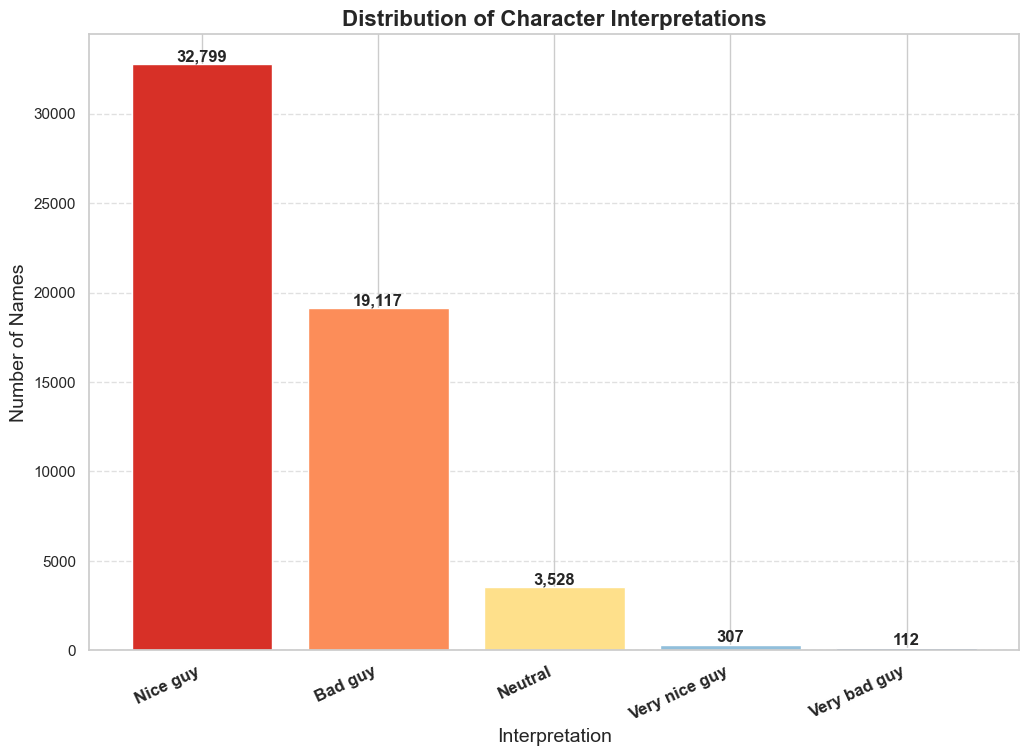

In [44]:
# Count interpretations and reorder
interpretation_counts = df_sentiment_analysis_textblob['Interpretation_SA'].value_counts()

# Create a prettier plot
plt.figure(figsize=(12, 8))
bars = plt.bar(
    interpretation_counts.index, 
    interpretation_counts.values, 
    color=['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4']
)

# Add annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize appearance
plt.title('Distribution of Character Interpretations', fontsize=16, fontweight='bold')
plt.xlabel('Interpretation', fontsize=14)
plt.ylabel('Number of Names', fontsize=14)
plt.xticks(rotation=25, ha='right', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## !! Normalement il fait ajouter "Interpretation SA"" dans processor -> NameFeaturess. Pour l'instant je l'ai fait avec df_char_cleaned, à modifier.

In [45]:
df_char_cleaned_SA.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0,2001-08-24
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,2001-08-24
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,2001-08-24
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,2001-08-24
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0,2001-08-24


In [46]:
df_char_cleaned_SA.rename(columns={'Character_name': 'Character_Name', 'Wikipedia_ID': 'Wikipedia_id'}, inplace=True)
df_merged = pd.merge(df_char_cleaned_SA, df_sentiment_analysis_textblob, left_on=['Wikipedia_id', 'Character_Name'], right_on=['Wikipedia_id', 'Character_Name'], how='inner')
df_merged.drop('Subjectivity', axis=1, inplace=True)
df_merged.head()

,Wikipedia_id,Name,Languages,Country,Genres,Character_Name,Sex,Actor_age,Release_date,Polarity,Interpretation_SA
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,2001-08-24,-0.021759,Bad guy
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,2001-08-24,-0.021759,Bad guy
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,2001-08-24,-0.021759,Bad guy
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Helena,F,52.0,2001-08-24,-0.096875,Bad guy
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Mars,M,NaN,2001-08-24,0.041667,Nice guy


## Results with Sentimental Analysis

In [47]:
df_SA_analysis = df_merged.copy()
df_SA_analysis['kindness'] = df_merged['Polarity'].apply(good_guy_detector)
df_SA_analysis = df_SA_analysis[df_SA_analysis['kindness'] != 'Not significant']
#df_SA_analysis.head(50)
df_sorted = df_SA_analysis[df_SA_analysis['Sex']=='F'].sort_values(by='Polarity', ascending=False)
df_sorted.head(50)


,Wikipedia_id,Name,Languages,Country,Genres,Character_Name,Sex,Actor_age,Release_date,Polarity,Interpretation_SA,kindness
56344,9825500,Fifty Pills,[English Language],[United States of America],"[Black comedy, Indie, Comedy]",Gracie,F,26.0,2007,1.000000,Very nice guy,1
45165,24436496,Equinox,[English Language],[United States of America],"[Crime Fiction, Drama, Indie]",Beverly,F,22.0,1992-09-18,1.000000,Very nice guy,1
18369,19136103,The Cold Room,"[German Language, English Language]",[United Kingdom],"[Thriller, Mystery, Science Fiction, Drama, Ro...",Sophie,F,NaN,1984-03-24,1.000000,Very nice guy,1
47424,11063492,Saving Shiloh,[English Language],[United States of America],"[Children's/Family, Family Drama, Childhood Dr...",Samantha,F,12.0,2006-05-12,1.000000,Very nice guy,1
35806,15513119,Who Loves the Sun,[English Language],[Canada],"[Romance Film, Drama, Indie, Comedy]",Maggie,F,33.0,2006-06-06,1.000000,Very nice guy,1
44692,3895377,Dirty Love,[English Language],[United States of America],"[Romantic comedy, Romance Film, Sex comedy, Co...",Carrie,F,32.0,2005-09-23,1.000000,Very nice guy,1
20531,25805385,White Wedding,"[Xhosa Language, Afrikaans Language, Zulu Lang...",[South Africa],"[Romantic comedy, Romance Film, Comedy, World ...",Ayanda,F,NaN,2009-04-29,1.000000,Very nice guy,1
56565,22165686,The Unidentified,[English Language],[United States of America],"[Romantic comedy, Indie, Drama, Comedy, Romant...",Brooke,F,NaN,2008-06,1.000000,Very nice guy,1
45954,33474264,Mardi Gras: Spring Break,[],[],[Comedy film],Erica,F,NaN,NaN,1.000000,Very nice guy,1
11728,13439139,27 Dresses,[English Language],[United States of America],"[Romantic comedy, Romance Film, Comedy]",Casey,F,32.0,2008-01-09,1.000000,Very nice guy,1


In [48]:
df_SA_analysis["Genre_Category"] = df_SA_analysis['Genres'].apply(lambda x: categorize_genre(x))

In [63]:
df_SA_analysis.shape

(23039, 13)

In [112]:
df_SA_by_genre = df_SA_analysis.explode(['Genre_Category'])
df_SA_by_genre.drop(columns=['Wikipedia_id','Name','Languages','Country','Actor_age','Release_date','Interpretation_SA','Character_Name','kindness','Genres'],inplace=True)
#df_SA_by_genre = df_SA_by_genre.groupby(['Genre_Category','Sex'])
df_SA_by_genre.head()

,Sex,Polarity,Genre_Category
5,F,-0.327778,Drama
5,F,-0.327778,Fantasy & Sci-Fi
5,F,-0.327778,Action & Adventure
6,F,0.080693,Comedy
6,F,0.080693,Drama


In [113]:
df_SA_by_genre.shape

(59282, 3)

In [114]:
#For the plot we are interested only in data with a specific genre, so we drop the rows with the genre 'Other'
df_SA_by_genre = df_SA_by_genre[df_SA_by_genre['Genre_Category']!='Other']
df_SA_by_genre.shape

(58855, 3)

In [115]:
#We assign to each polarity value to the midpoint of the interval they fall into
bins = np.arange(-1, 1.1, 0.1)  
midpoints = bins[:-1] + 0.05

df_SA_by_genre['Binned_Polarity'] = pd.cut(df_SA_by_genre['Polarity'],bins=bins,labels=midpoints)
df_SA_by_genre.head()

,Sex,Polarity,Genre_Category,Binned_Polarity
5,F,-0.327778,Drama,-0.35
5,F,-0.327778,Fantasy & Sci-Fi,-0.35
5,F,-0.327778,Action & Adventure,-0.35
6,F,0.080693,Comedy,0.05
6,F,0.080693,Drama,0.05


In [116]:
df_SA_by_genre.drop(columns=['Polarity'],inplace=True)


In [117]:
df_SA_by_genre = df_SA_by_genre.groupby(['Genre_Category','Sex','Binned_Polarity']).agg(count =('Binned_Polarity','count')).reset_index()


/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_68705/724504533.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [118]:
df_SA_by_genre.head()

,Genre_Category,Sex,Binned_Polarity,count
0,Action & Adventure,F,-0.95,0
1,Action & Adventure,F,-0.85,3
2,Action & Adventure,F,-0.75,0
3,Action & Adventure,F,-0.65,4
4,Action & Adventure,F,-0.55,6


TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

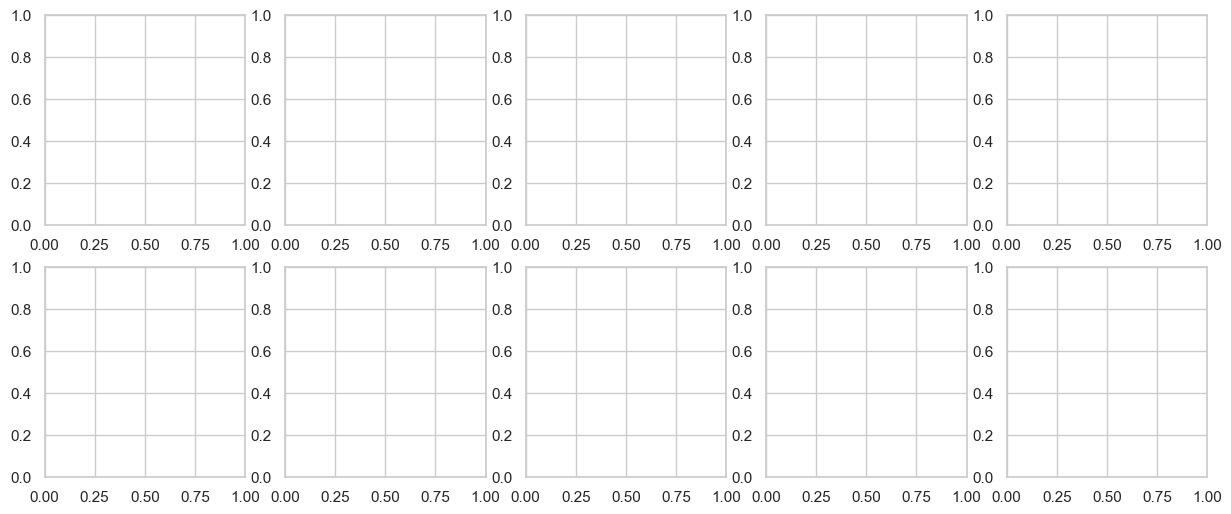

In [120]:
#Plot

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
genres = ['Action & Adventure','Drama','Comedy','Horror & Thriller','Fantasy & Sci-Fi','Historical & War','Romance','Documentary','Music & Performance','Cult & B-Movies']

for i,ax in enumerate(axes.flat):

    filtered_F = df_SA_by_genre[
        (df_SA_by_genre['Genre_Category'] == genres[i]) & 
        (df_SA_by_genre['Sex'] == 'F')
    ]
    
    filtered_M = df_SA_by_genre[
        (df_SA_by_genre['Genre_Category'] == genres[i]) & 
        (df_SA_by_genre['Sex'] == 'M')
    ]
    ax.plot(filtered_F['Binned_Polarity'],filtered_F['count'],color='green', label='Female')
    ax.plot(filtered_M['Binned_Polarity'],filtered_M['count'],color='red', label = 'Male')

    ax.set_title(genres[i])
    ax.legend()

plt.tight_layout()
plt.show()

In [49]:
analyze_SA = GoodBadGuyAnalyzer(df_SA_analysis)

bad_guys_names, bad_girls_names = analyze_genre.get_top_names_by_genre(10)

data_f = analyze_genre.create_sunburst_data(bad_girls_names)
data_m = analyze_genre.create_sunburst_data(bad_guys_names)

In [50]:
# Create the sunburst plots for females and males
fig_females = go.Figure(go.Sunburst(
    labels=data_f['character'],
    parents=data_f['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_males = go.Figure(go.Sunburst(
    labels=data_m['character'],
    parents=data_m['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Females", "Males"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_females['data'][0], row=1, col=1)
fig.add_trace(fig_males['data'][0], row=1, col=2)

fig.update_layout(
    title_text="TOP 10 Vilain Names by Genre and Gender (Press on the Genre to see the names)",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig.show()

### Pre processing pour Roberta

La fonction ci-dessous permet de réduire aléatoirement le nombre de phrases affiliées à un prénom. La valeur "MAX_SENTENCES" peut être fixée manuellement pour plus ou moins de précision. 

In [51]:
# list_characters = df_sentences_by_names["Character_Name"]
# MAX_SENTENCES = 100  # À ajuster selon besoin

# df_reduced = []

# for idx, row in df_sentences_by_names.iterrows():
#     if row["Sentence_Count"] > MAX_SENTENCES:
#         reduced_sentences = pd.Series(row["Sentences"]).sample(MAX_SENTENCES, random_state=42).tolist()
#     else:
#         reduced_sentences = row["Sentences"]
    
#     df_reduced.append({
#         "Character_Name": row["Character_Name"],
#         "Sentences": reduced_sentences,
#         "Sentence_Count": len(reduced_sentences)
#     })

# df_reduced = pd.DataFrame(df_reduced)

### Fonctions pour Roberta SA

In [52]:
# from transformers import pipeline

# def get_sentiment_with_roberta(sentence):
#     sentiment_pipeline = pipeline('sentiment-analysis', model='roberta-large-mnli')
#     result = sentiment_pipeline(sentence)
#     return result[0]["score"]

# def process_character_sentiments_roberta(sentences):
#     sentences_roberta = []
    
#     for sentence in sentences:
#         sentiment_with_roberta = get_sentiment_with_roberta(sentence)
#         sentences_roberta.append(sentiment_with_roberta)
    
#     mean_sentiment_roberta = np.mean(sentences_roberta) if sentences_roberta else None
    
#     return mean_sentiment_roberta

In [53]:
# data_roberta = []

# for index, character_name in enumerate(list_characters):
#     list_sentences_by_character = df_reduced["Sentences"].iloc[index]
    
#     mean_sentiment_roberta = process_character_sentiments_roberta(list_sentences_by_character)

#     data_roberta.append({
#         "Character_Name": character_name,
#         "Sentiment": mean_sentiment_roberta
#     })

# df_sentiment_analysis_roberta = pd.DataFrame(data_roberta)
# print(df_sentiment_analysis_roberta)

### Regrouper les phrases par prénoms

In [54]:
# # Rassemble les phrases par prénoms

# df = pd.DataFrame(data)
# df['Sentence_Count'] = df['Sentences'].apply(len)
# df = df[df['Sentences'].apply(lambda x: len(x) > 0)]

# grouped_sentences_by_names = {}

# for index, row in df.iterrows():
#     character_name = row['Character_Name']
#     sentences = row['Sentences']
    
#     if character_name in grouped_sentences_by_names:
#         grouped_sentences_by_names[character_name].extend(sentences)  
#     else:
#         grouped_sentences_by_names[character_name] = sentences 

# grouped_sentences_by_names_list = []

# for character_name, sentences in grouped_sentences_by_names.items():
#     grouped_sentences_by_names_list.append({
#         'Character_Name': character_name,
#         'Sentences': sentences,
#         'Sentence_Count': len(sentences)
#     })

# df_sentences_by_names = pd.DataFrame(grouped_sentences_by_names_list)
# print(df_sentences_by_names)